# Pre stuff
## Simplest of things

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from datetime import datetime as dt
from givenFncs import generate_data


def σ(x):
    return np.tanh(x)


def dσ(x):
    # return 1 / np.cosh(x)**2 # our
    return 1.0 - np.tanh(x) ** 2


def η(x):  # max [0, 1]
    return (1.0 + np.tanh(x / 2.0)) / 2.0


def dη(x):
    # return 1/(2 * np.cosh(x) + 2) # our
    return 0.25 * (1.0 - np.tanh(x / 2.0) ** 2)


def scale(y, α=0, β=1):
    b = np.max(y)
    a = np.min(y)
    return ((b - y)*α + (y - a)*β) / (b-a)


def scaleBack(sy, c, α=0, β=1):
    b = np.max(c)
    a = np.min(c)
    return sy*(b - a)/(β - α) - (b*α - a*β)/(β-α)

## Classes 

In [8]:
class Model():
    """Base model:
        It holds startup informasjon about the model and the network used in this method.
    """

    def __init__(self, Y0, C, K, weigths=None):
        """Set values"""
        self.d = len(Y0)
        self.I = len(Y0[0])
        self.C = C  # Ska denna vær init her?
        self.K = K
        self.h = None
        self.j = 0  # Iterations
        self.Υ = np.zeros_like(self.C)
        self.Y0 = Y0
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5 * np.linalg.norm(self.Υ - self.C)**2
        self.Jθlog = []
        if weigths:  # Imports weigths
            self.startθ = weigths
        else:  # set random weights
            self.startθ = {'W': np.random.rand(self.K, self.d, self.d),
                           'b': np.random.rand(self.K, self.d, 1),
                           'w': np.random.rand(self.d, 1),
                           'μ': np.random.rand()}
        """Memory allocation"""
        self.θ = self.copyWeights(self.startθ)
        self.Z = np.zeros((K+1, self.d, self.I))
        self.Z[0] = Y0
        # One less than intended bc P[0] is not used
        self.P = np.zeros((K, self.d, self.I))
        self.dθ = {'W': np.zeros((self.K, self.d, self.d)),
                   'b': np.zeros((self.K, self.d, 1)),
                   'w': np.zeros((self.d, 1)),
                   'μ': 0}

    def __repr__(self):
        pass

    def __len__(self):
        return self.I

    def copyWeights(self, weights):
        θ = {'W': weights['W'].copy(),
             'b': weights['b'].copy(),
             'w': weights['w'].copy(),
             'μ': weights['μ']}
        return θ

    def copy(self):
        θ = self.copyWeights(self.θ)
        return Model(self.Y0.copy(), self.C.copy(), self.K, θ)

    def computeZ(self, W, b, h, K):  # (4)
        for k in range(K):
            self.Z[k+1] = self.Z[k] + h * σ(W[k] @ self.Z[k] + b[k])

    def backwardPropagation(self, W, b, w, μ, Z, h, K):
        # Save computation
        Zxw = Z[-1].T @ w + μ
        # Update variables (Approximation)
        self.Υ = η(Zxw).T  # (5)
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5*np.linalg.norm(self.ΥmC)**2
        # Compute last P[K]
        self.P[self.K-1] = np.outer(w, (self.ΥmC * dη(Zxw).T))  # (10) (verified)
        """Backward propagation"""
        for k in range(K-1, 0, -1):  # Change P index to K+1
            self.P[k-1] = self.P[k] + h*W[k].T @ (dσ(W[k] @ Z[k] + b[k]) * self.P[k])  # (11)

    def computeGradients(self, W, b, w, μ, Z, P, h, K):
        # save computation
        dηZw = dη(Z[K].T @ w + μ)
        # compute (8) and (9)
        self.dθ['μ'] = dηZw.T @ self.ΥmC.T
        self.dθ['w'] = Z[K] @ (self.ΥmC.T * dηZw)
        # Compute (12) and (13)
        for k in range(K):
            # Save computation
            PhadσWZ = h * P[k] * dσ(W[k] @ Z[k] + b[k])
            self.dθ['W'][k] = PhadσWZ @ Z[k].T
            self.dθ['b'][k] = PhadσWZ @ np.ones((self.I, 1))

    def update(self):
        self.computeZ(self.θ['W'], self.θ['b'], self.h, self.K)
        self.backwardPropagation(self.θ['W'], self.θ['b'], self.θ['w'], self.θ['μ'], self.Z, self.h, self.K)
        self.computeGradients(self.θ['W'], self.θ['b'], self.θ['w'], self.θ['μ'], self.Z, self.P, self.h, self.K)

    def setInput(self, Y0, C):
        self.Y0 = Y0.copy()
        self.Z[0] = Y0.copy()
        self.C = C.copy()
        self.d = len(Y0)
        self.I = len(Y0[0])
        self.Υ = np.zeros_like(self.C)
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5 * np.linalg.norm(self.Υ - self.C)**2
        self.j = 0

    def restart(self):
        self.θ = self.copyWeights(self.startθ)
        self.j = 0
        self.Υ = np.zeros_like(self.C)
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5 * np.linalg.norm(self.Υ - self.C)**2

    def getGrads(self):
        h = self.h
        K = self.K
        Z = self.Z.copy()
        W = self.θ['W']
        b = self.θ['b']
        w = self.θ['w']
        μ = self.θ['μ']

        # algorithm
        A = np.dot(w, dη(np.dot(w.T, Z[K]) + μ))
        for k in range(K, 0, -1):
            A = A + W[k-1].T @ (h * dσ(W[k-1] @ Z[k-1] + b[k-1]) * A)
        return A


class Adam():
    def __init__(self, model, Jθlogs=None):
        self.M = model
        self.maxiter = None
        self.m = {'W': np.zeros((model.K, model.d, model.d)),
                  'b': np.zeros((model.K, model.d, 1)),
                  'w': np.zeros((model.d, 1)),
                  'μ': 0}
        self.v = self.m.copy()
        # Logging purposes
        self.numLogs = Jθlogs

    def __repr__(self):
        # re = f'Adam, h={self.M.h}, K={self.M.K}, iter={self.maxiter}, Jθ={round(self.M.Jθ, 5)}'
        re = 'Adam'
        return re

    def name(self):
        return 'Adam'

    def algo(self):
        β1 = 0.9
        β2 = 0.999
        α = 0.01
        ϵ = 1e-8
        for key in self.m.keys():
            self.m[key] = β1*self.m[key] + (1-β1)*self.M.dθ[key]
            self.v[key] = β2*self.v[key] + (1-β2)*np.square(self.M.dθ[key])

            m = self.m[key] / (1 - β1**self.M.j)
            v = self.v[key] / (1 - β2**self.M.j)
            self.M.θ[key] -= α * m / (np.sqrt(v) + ϵ)

    def run(self, h, tol, maxiter):
        self.M.h = h
        self.maxiter = maxiter
        self.M.update()
        while self.M.Jθ > tol and self.M.j <= maxiter:
            self.M.j += 1
            self.algo()
            self.M.update()
        self.M.Jθlog.append([self.M.h, self.M.Jθ])


class PVGD():
    """Plain Vanilla Gradient Descent optimizer
    """

    def __init__(self, model):
        self.M = model
        self.τ = None
        self.maxiter = None
        self.log = {}

    def __repr__(self):
        # re = f'PVGD, h={self.M.h}, τ={self.τ}, K={self.M.K}, iter={self.M.j}, Jθ={round(self.M.Jθ, 5)}'
        re = 'PVGD'
        return re

    def name(self):
        return 'PVGD'

    def run(self, h, τ, tol, maxiter, ):
        self.M.h = h
        self.τ = τ
        self.maxiter = maxiter
        self.log[(τ, maxiter)] = []
        while self.M.Jθ > tol and self.M.j < maxiter:
            self.M.j += 1
            self.M.update()
            for key in self.M.θ:
                self.M.θ[key] -= self.τ * self.M.dθ[key]
                # if self.M.j % 10 == 0:
                #     self.log[(τ, maxiter)].append(self.M.Jθ)
            # self.plotProg()

    def plotProg(self):
        if self.M.j % 1000 == 0:
            # plt.plot(self.log[(self.τ, self.maxiter)][:][1], self.log[(self.τ, self.maxiter)][:][0])
            plt.plot(self.M.γ)
            plt.title(f'{self.log.keys()}')
            plt.show()

## UI fncs

In [9]:


def plotApprox(C, *args, x=np.array([])):
    """Plots optimzers best approximation to one set of training data

    Args:
        C       (ndarray)          : The exact value
        *args   (tuple)            : tuple of optimized models that should be compared
        x       (ndarray, optional): The x-axis of the training data. Defaults to np.array([]).
    """
    if len(x) == 0:
        x = np.linspace(0, 1, args[0].M.I)
    for mod in args:
        lbl = mod.name()
        if lbl == 'PVGD':
            lbl += ', h={}, τ={}'.format(mod.M.h, mod.τ)
        else:
            lbl += ', h={}'.format(mod.M.h)
        plt.plot(x, scaleBack(mod.M.Υ[0], C), label=lbl)

    if C.shape[0] == 1:
        plt.plot(x, C[0], label='F(y)', ls='--')
    else:
        plt.plot(x, C, label='F(y)', ls='--')
    plt.title(r'Comparing $\tilde{F}(y)$ with $F(y)$')
    plt.legend()
    plt.show()

## Fnc to find h and $\tau$

In [26]:
def findhτPVGD(m, hmM, τmM, hn, τn, tol=1e-4, maxiter=1e4):
    hList = np.linspace(hmM[0], hmM[1], hn)
    τList = np.linspace(τmM[0], τmM[1], τn)
    hEp = {}  # in case of error (error proof)
    Jθ = {}
    r = 0
    tot = len(hList)*len(τList)
    for τ in τList:
        hEp[τ] = []
        Jθ[τ] = []
        try:
            for h in hList:
                r += 1
                start = dt.now()
                m.run(h, τ, tol, maxiter)
                end = dt.now()
                Jθ[τ].append(m.M.Jθ)
                hEp[τ].append(h)
                m.M.restart()
                print(f'run {r}/{tot}, runtime: {end-start}')
        except Exception as e:
            print(e, 'h =', h)

    bestJ = 1e7
    for τ, h in hEp.items():
        plt.plot(h, Jθ[τ], label=r'$\tau={}$'.format(round(τ, 5)))
        hi = 0
        for J in Jθ[τ]:
            if J < bestJ:
                bestJ = J
                τatBest = [τ, h[hi]]
            hi += 1

    print(f'\nBest Jθ={bestJ} when τ={τatBest[0]}, h={τatBest[1]}')

    plt.title(r'$J(\theta)$ with $K={}$, $I={}$'.format(m.M.K, m.M.I))
    plt.legend()
    plt.show()

## Setup
Cell below fixes the weights and layers for the next cells

In [36]:
    Ifrom = 0
    Ito = 4096
    maxiter = 1e4
    tol = 1e-9

    # Training 1
    batch0 = generate_data(0)

    # y0 = scale(batch0['P'][:, Ifrom:Ito])
    y0 = batch0['P'][:, Ifrom:Ito]
    t0 = scale(batch0['t'][Ifrom:Ito], 0, 1)
    C_T1 = np.array([batch0['T'][Ifrom:Ito]])
    C_T1scaled = scale(C_T1, 0, 1)
    # Setup model
    modT = Model(y0, C_T1scaled, 10)
    # PVGD
    PVGDOptBatch = PVGD(modT.copy())

# Set h and $\tau$

In [40]:
hFrom = 0.29
hTo   = 0.5
τFrom = 0.0001
τTo   = 0.0008
hSteps = 4
τSteps = 4

## Runs
### Run 1

run 1/4, runtime = 0:00:05.222880
run 2/4, runtime = 0:00:05.679815
run 3/4, runtime = 0:00:05.322426
run 4/4, runtime = 0:00:05.600573
Best Jθ=0.03921727850136714 when τ=0.2, h=0.2


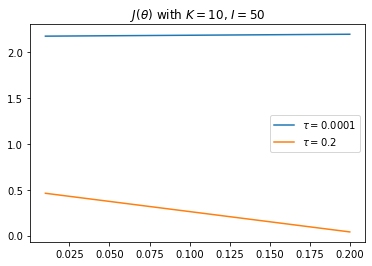

In [24]:
findhτPVGD(PVGDOptBatch, (hFrom, hTo), (τFrom, τTo), hSteps, τSteps)

### Run 2

run 1/16, runtime: 0:00:09.533491
run 2/16, runtime: 0:00:10.136241
run 3/16, runtime: 0:00:11.571453
run 4/16, runtime: 0:00:11.662452
run 5/16, runtime: 0:00:09.749579
run 6/16, runtime: 0:00:11.706601
run 7/16, runtime: 0:00:12.373267
run 8/16, runtime: 0:00:12.016369
run 9/16, runtime: 0:00:09.291639
run 10/16, runtime: 0:00:12.584150
run 11/16, runtime: 0:00:12.982797
run 12/16, runtime: 0:00:12.893534
run 13/16, runtime: 0:00:11.862008
run 14/16, runtime: 0:00:12.799636
run 15/16, runtime: 0:00:12.865333
run 16/16, runtime: 0:00:11.796858

Best Jθ=0.01748829818406522 when τ=0.06673333333333334, h=0.07333333333333333


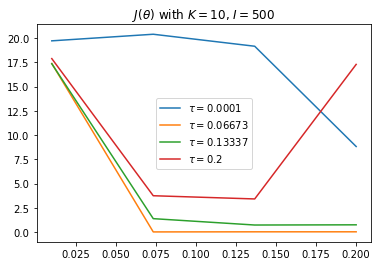

In [30]:
findhτPVGD(PVGDOptBatch, (hFrom, hTo), (τFrom, τTo), hSteps, τSteps)

run 1/16, runtime: 0:00:15.551288
run 2/16, runtime: 0:00:17.631967
run 3/16, runtime: 0:00:19.578662
run 4/16, runtime: 0:00:20.747554
run 5/16, runtime: 0:00:18.840358
run 6/16, runtime: 0:00:19.422129
run 7/16, runtime: 0:00:20.177365
run 8/16, runtime: 0:00:21.935533
run 9/16, runtime: 0:00:20.066099
run 10/16, runtime: 0:00:20.479939
run 11/16, runtime: 0:00:20.902122
run 12/16, runtime: 0:00:21.738031
run 13/16, runtime: 0:00:21.233981
run 14/16, runtime: 0:00:21.157295
run 15/16, runtime: 0:00:22.264664
run 16/16, runtime: 0:00:20.613880

Best Jθ=0.01572050870964845 when τ=0.053366666666666666, h=0.22333333333333333


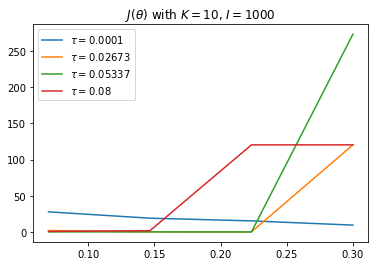

In [33]:
findhτPVGD(PVGDOptBatch, (hFrom, hTo), (τFrom, τTo), hSteps, τSteps)

run 1/16, runtime: 0:01:10.445673
run 2/16, runtime: 0:01:13.677135
run 3/16, runtime: 0:01:09.845882
run 4/16, runtime: 0:01:11.662202
run 5/16, runtime: 0:01:17.276985
run 6/16, runtime: 0:01:26.073839
run 7/16, runtime: 0:01:20.166057
run 8/16, runtime: 0:01:20.000817
run 9/16, runtime: 0:01:22.415717
run 10/16, runtime: 0:01:23.887044
run 11/16, runtime: 0:01:40.615484
run 12/16, runtime: 0:01:40.748006
run 13/16, runtime: 0:01:37.874903
run 14/16, runtime: 0:01:36.805196
run 15/16, runtime: 0:01:33.183806
run 16/16, runtime: 0:01:27.837332

Best Jθ=0.41228564729782124 when τ=0.006066666666666666, h=0.29


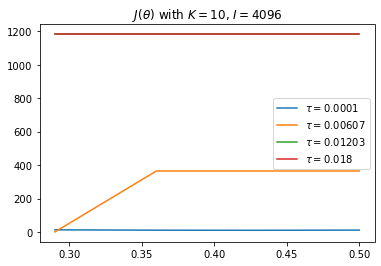

In [39]:
findhτPVGD(PVGDOptBatch, (hFrom, hTo), (τFrom, τTo), hSteps, τSteps)

run 1/16, runtime: 0:01:23.973034
run 2/16, runtime: 0:01:19.178372
run 3/16, runtime: 0:01:32.899814
run 4/16, runtime: 0:01:40.924832
run 5/16, runtime: 0:01:36.432753
run 6/16, runtime: 0:01:23.505831
run 7/16, runtime: 0:01:28.762904
run 8/16, runtime: 0:01:32.111384
run 9/16, runtime: 0:01:26.464714
run 10/16, runtime: 0:01:27.438381
run 11/16, runtime: 0:01:10.852422
run 12/16, runtime: 0:01:10.702869
run 13/16, runtime: 0:01:26.014279
run 14/16, runtime: 0:01:14.802651
run 15/16, runtime: 0:01:16.354292
run 16/16, runtime: 0:01:23.004323

Best Jθ=0.896627170558753 when τ=0.0008, h=0.43


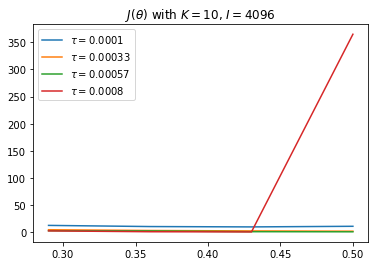

In [41]:
findhτPVGD(PVGDOptBatch, (hFrom, hTo), (τFrom, τTo), hSteps, τSteps)